In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, ConcatDataset
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as F

# Aprendizaje Continuado

> Autor: Jorge García González (Universidad de Málaga)

> Última Actualización: 10/12/2025

> Asignatura: Programación para la Inteligencia Artificial

La aproximación al aprendizaje que hemos estado siguiendo en el curso es ajustar los pesos de una red para que sus predicciones encajen con un conjunto de datos dado con el objetivo de aproximar una función. Tenemos los datos que queremos ajustar, entrenamos el modelo y, una vez entrenado, lo usamos. Entrenar y usar. Dos fases bien diferenciadas que siguen en términos generales todas las aproximaciones de aprendizaje computacional. Y es que así funcionamos las personas. Primero aprendemos y luego usamos lo aprendido sin aprender nada más. ¿no?

Obviamente no. Los humanos (supuestos ejemplos de entidades inteligentes) estamos aprendiendo continuamente. Tanto a resolver nuevos problemas como a resolver mejor problemas que ya conocemos. Esto, sin embargo, no se ajusta bien al enfoque del Aprendizaje Profundo que hemos visto hasta ahora. Cada vez que hemos entrenado un modelo, lo hemos hecho de cero. Para modelos que tardan en entrenarse unos minutos no es mucho problema, pero si entrenar es más costoso (en tiempo, espacio o dinero) quizás queremos "aprovechar" modelos ya entrenados y que funcionan bien pero aumentar el conjunto de datos con el que fue entrenado.

En Aprendiaje Profundo, esta idea de "usar" un modelo ya entrenado para aprender más se puede traducir a muchas ideas y tñecnicas. Transferencia de Aprendizaje, Destilación de Conocimiento, Ajuste Fino... Nosotros no vamos a centrarnos ahora en ninguna de ellas sino que vamos a evidenciar un problema más básico.

Supongamos que tenemos un modelo $m_{\theta}$ entrenado con el conjunto $C_{A}$ para la tarea A (clasificar imágenes entre perros, zorros y gatos, por ejemplo). Sin embargo, observamos que nuestro modelo $m_{\theta}$ no funciona bien ante cierto tipo de ejemplos porque no se tuvieron en cuenta en el conjunto de datos original (en $C_{A}$ todos los perros son pastores o terriers y el modelo falla con las fotos de chihuahas). ¿Qué hacemos? Podemos generar un conjunto $C_{A}'$ que incluya ejemplos de aquellos casos en los que el modelo falla y entrenarlo de cero, pero es que $m_{\theta}$ funciona ya bastante bien. ¿No hay otra opción que empezar un entrenamiento de 0?

Supongamos que decidimos que nuestro modelo $m_{\theta}$ además de realizar la tarea A, también realice la tarea B (que además clasifique conejos, libres y coballas) para lo que tenemos un conjunto $C_{B}$. ¿No queda otra que crear un conjunto que una $C_{A}$ y $C_{B}$ y empezar de cero?

Vamos a hacer un experimento del segundo supuesto (para el primero es más dificil conseguir datos apropiados).

Primero vamos a rescatar algunas funciones útiles y a descargar el MNIST.

In [2]:
device = 'cuda'
device = torch.device("cuda:0" if (device == 'cuda') and torch.cuda.is_available() else "cpu")
print(device)

DRIVE=False
if DRIVE:
  from google.colab import drive
  drive.mount('/content/drive')
  workpath = '/content/drive/MyDrive/Work/Docencia UMA/2025-2026/Programacion para la IA/data'
else:
  workpath = '/workspace/data'

cuda:0


In [3]:
train_dataset = datasets.MNIST(root=workpath, train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root=workpath, train=False, download=True, transform=transforms.ToTensor())

In [4]:
class CudaDataset(Dataset):
  def __init__(self, dataset, device, transform = None):
    self.dataset = dataset
    self.cuda_y = []
    self.cuda_x = []
    self.device = device
    self.transform = transform

    for x, y in tqdm(self.dataset, desc="Moving to GPU"):
      self.cuda_x.append(x.to(self.device))
      self.cuda_y.append(torch.tensor(y, device=self.device))

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    if self.transform is None:
      x = self.cuda_x[idx]
    else:
      x = self.transform(self.cuda_x[idx])
    return x, self.cuda_y[idx]

def split_dataset(dataset, split_share=0.9):
  """
  Devuelve dos subconjuntos del dataset. split_share define cuántos ejemplos irán al
  primer subconjunto. El resto irán al segundo.
  """
  mask_indices_to_first_subset = torch.rand(len(dataset))<=split_share
  indices_first_subset = [i for i, (_, _) in enumerate(dataset) if mask_indices_to_first_subset[i]]
  indices_second_subset = [i for i, (_, _) in enumerate(dataset) if not mask_indices_to_first_subset[i]]

  first_subset = torch.utils.data.Subset(dataset, indices_first_subset)
  second_subset = torch.utils.data.Subset(dataset, indices_second_subset)

  return first_subset, second_subset

def filter_dataset(dataset, chosen_labels):
  """
  Devuelve un subconjunto del dataset que solo contiene las etiquetas especificadas.
  """
  indices = [i for i, (_, y) in enumerate(dataset) if y in chosen_labels]
  subset = torch.utils.data.Subset(dataset, indices)
  return subset

Ahora vamos a dividir el conjunto en 2 tareas. La tarea A consiste en clasificar los dígitos del 0 al 4, la B en clasificar los dígitos del 5 al 9. Creamos los correspondientes conjuntos para cada tarea.

In [5]:
train_dataset, val_dataset = split_dataset(train_dataset)
labels_A = [0,1,2,3,4]
labels_B = [5,6,7,8,9]

train_dataset_A = filter_dataset(train_dataset, labels_A)
test_dataset_A = filter_dataset(test_dataset, labels_A)
val_dataset_A = filter_dataset(val_dataset, labels_A)

train_dataset_B = filter_dataset(train_dataset, labels_B)
test_dataset_B = filter_dataset(test_dataset, labels_B)
val_dataset_B = filter_dataset(val_dataset, labels_B)

if not str(device)=="cpu":
  train_dataset_A = CudaDataset(train_dataset_A, device)
  val_dataset_A = CudaDataset(val_dataset_A, device)
  test_dataset_A = CudaDataset(test_dataset_A, device)
  train_dataset_B = CudaDataset(train_dataset_B, device)
  val_dataset_B = CudaDataset(val_dataset_B, device)
  test_dataset_B = CudaDataset(test_dataset_B, device)

Moving to GPU: 100%|██████████| 4861/4861 [00:00<00:00, 8608.03it/s]


In [6]:
print(f"Número de ejemplos en entrenamiento A: {len(train_dataset_A)}")
print(f"Número de ejemplos en validación A: {len(val_dataset_A)}")
print(f"Número de ejemplos en test A: {len(test_dataset_A)}")
print(f"Número de ejemplos en entrenamiento B: {len(train_dataset_B)}")
print(f"Número de ejemplos en validación B: {len(val_dataset_B)}")
print(f"Número de ejemplos en test B: {len(test_dataset_B)}")

Número de ejemplos en entrenamiento A: 27496
Número de ejemplos en validación A: 3100
Número de ejemplos en test A: 5139
Número de ejemplos en entrenamiento B: 26481
Número de ejemplos en validación B: 2923
Número de ejemplos en test B: 4861


Y vamos a crearnos un bucle de entrenamiento que simplemente nos muestre el error de validación para dos conjuntos de validación distintos mientras entrena.

In [7]:
def val_epoch(val_dataloader, model, loss_fn):
  val_step_loss_list = []
  val_correct_answers = 0
  val_set_size = 0
  with torch.no_grad():
    for x_val_true, y_val_true in val_dataloader:
      y_val_pred = model(x_val_true)

      loss_val = loss_fn(y_val_pred, y_val_true)
      val_step_loss_list.append(loss_val)

      correct_answers = torch.sum(y_val_true==torch.argmax(y_val_pred, dim=-1))
      val_correct_answers += correct_answers
      val_set_size += y_val_true.numel()

      val_loss = torch.tensor(val_step_loss_list).mean()

  return val_loss, val_correct_answers, val_set_size


def learning_loop_for_classification_with_two_tasks(train_dataloader, val_dataloader_task_A, val_dataloader_task_B, model, epochs, loss_fn, optimizer, validation_freq):
  epoch_loss_list = []
  val_A_loss_list = []
  val_A_acc_list = []
  val_B_loss_list = []
  val_B_acc_list = []

  with tqdm(range(epochs), desc="epoch:") as pbar:
    for epoch in pbar:
      model.train()
      steps_loss_list = []
      for x_true, y_true in train_dataloader:
        y_pred = model(x_true)                              # Forward
        optimizer.zero_grad()
        loss = loss_fn(y_pred, y_true)
        loss.backward()                                     # Backward
        steps_loss_list.append(loss.clone().detach())
        optimizer.step()
      train_loss = torch.tensor(steps_loss_list).mean()
      epoch_loss_list.append(train_loss)
      pbar.set_postfix(loss=f"{train_loss}")

      if epoch%validation_freq==0:
          model.eval()
          val_A_loss, val_A_correct_answers, val_A_set_size = val_epoch(val_dataloader_task_A, model, loss_fn)
          val_A_loss_list.append(val_A_loss)
          val_A_acc_list.append(val_A_correct_answers/float(val_A_set_size))

          val_B_loss, val_B_correct_answers, val_B_set_size = val_epoch(val_dataloader_task_B, model, loss_fn)
          val_B_loss_list.append(val_B_loss)
          val_B_acc_list.append(val_B_correct_answers/float(val_B_set_size))

  return model, epoch_loss_list, val_A_loss_list, val_A_acc_list, val_B_loss_list, val_B_acc_list

Ahora vamos a entrenar para la tarea A mientras observamos el conjunto de validación de las dos tareas.

In [8]:
torch.manual_seed(0)

batch_size = 1024
learning_rate = 1e-3
epochs = 50
loss_fn = torch.nn.CrossEntropyLoss()
validation_freq = 1

model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(28*28,64),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(64,10)
).to(device)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate
  )

train_dataloader_A = DataLoader(train_dataset_A, batch_size=batch_size, shuffle=True)
val_dataloader_A = DataLoader(val_dataset_A, batch_size=batch_size, shuffle=True)
test_dataloader_A = DataLoader(test_dataset_A, batch_size=batch_size, shuffle=False)
train_dataloader_B = DataLoader(train_dataset_B, batch_size=batch_size, shuffle=True)
val_dataloader_B = DataLoader(val_dataset_B, batch_size=batch_size, shuffle=True)
test_dataloader_B = DataLoader(test_dataset_B, batch_size=batch_size, shuffle=False)

model, train_loss_list, val_A_loss_list, val_A_acc_list, val_B_loss_list, val_B_acc_list = learning_loop_for_classification_with_two_tasks(
    train_dataloader_A,
    val_dataloader_A,
    val_dataloader_B,
    model,
    epochs,
    loss_fn,
    optimizer,
    validation_freq = validation_freq)

print(f"Número de parámetros {torch.tensor([p.numel() for p in model.parameters()]).sum()}")

epoch:: 100%|██████████| 50/50 [00:06<00:00,  8.10it/s, loss=0.021537993103265762]

Número de parámetros 50890


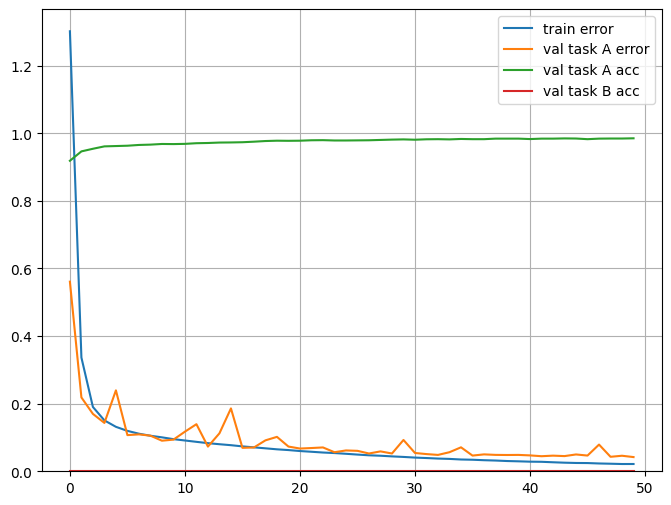

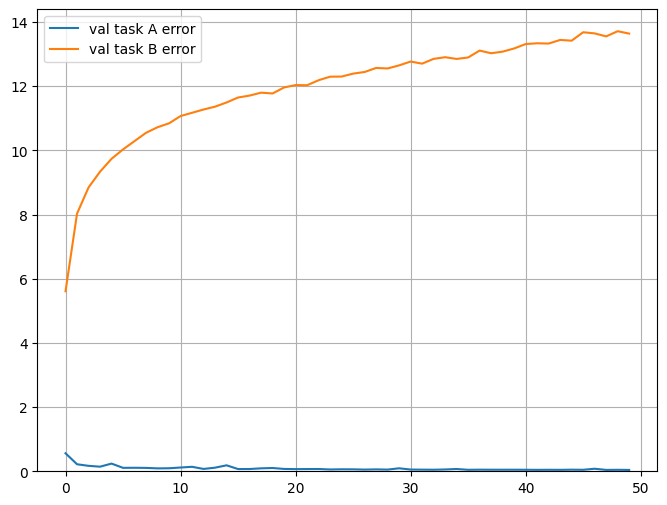

In [9]:
plt.figure(figsize=(8,6))
plt.plot(range(len(train_loss_list)), [l.cpu() for l in train_loss_list], label="train error")
plt.plot(range(0, validation_freq*len(val_A_loss_list), validation_freq), [l.cpu() for l in val_A_loss_list], label="val task A error")
plt.plot(range(0, validation_freq*len(val_A_acc_list), validation_freq), [l.cpu() for l in val_A_acc_list], label="val task A acc")
plt.plot(range(0, validation_freq*len(val_B_acc_list), validation_freq), [l.cpu() for l in val_B_acc_list], label="val task B acc")
#plt.plot(range(0, validation_freq*len(val_B_loss_list), validation_freq), [l.cpu() for l in val_B_loss_list], label="val task B error")
plt.legend()
plt.grid(True)
plt.ylim(bottom=0)
plt.show()

plt.figure(figsize=(8,6))
plt.plot(range(0, validation_freq*len(val_A_loss_list), validation_freq), [l.cpu() for l in val_A_loss_list], label="val task A error")
plt.plot(range(0, validation_freq*len(val_B_loss_list), validation_freq), [l.cpu() for l in val_B_loss_list], label="val task B error")
plt.legend()
plt.grid(True)
plt.ylim(bottom=0)
plt.show()

Lo esperable, ¿no? Hemos entrenado para la tarea A y el error de validación de la tarea A baja mientras su accuracy sube a casi 1. Por su parte, el error en la tarea B sube y su accuracy permanece en 0 todo el tiempo. ¿Qué podíamos esperar? En ningún momento le hemos enseñado al modelo ejemplos de la tarea B. El error de validación de la tarea B aumenta con el tiempo simplemente porque, inicializado aleatoriamente, las salidas del modelo podrían acercarse a acertar algunas veces para la tarea B (por puro azar). Sin embargo, el modelo al entrenarse se ajusta para dar resultados cada vez más alejados de los de la tarea B (porque está resolviendo la A). Aprende a decir cada vez con mayor confianza que la imagen es un dígito entre 0 y 4 aunque le demos como entrada dígitos entre 5 y 9.

A continuación, en lugar de entrenar un modelo de 0, vamos a aprovechar el modelo que ya tenemos para la tarea A y vamos a entrenarlo para la tarea B mientras seguimos observando qué ocurre con el error de validación para ambas tareas (nótese que inicializo un nuevo optimizador para no arrastrar los valores del anterior, pero no un nuevo modelo).

In [10]:
torch.manual_seed(0)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate
  )

model, train_loss_list, val_A_loss_list, val_A_acc_list, val_B_loss_list, val_B_acc_list = learning_loop_for_classification_with_two_tasks(
    train_dataloader_B,
    val_dataloader_A,
    val_dataloader_B,
    model,
    epochs,
    loss_fn,
    optimizer,
    validation_freq = validation_freq)

print(f"Número de parámetros {torch.tensor([p.numel() for p in model.parameters()]).sum()}")

epoch:: 100%|██████████| 50/50 [00:05<00:00,  8.35it/s, loss=0.06962647289037704]

Número de parámetros 50890


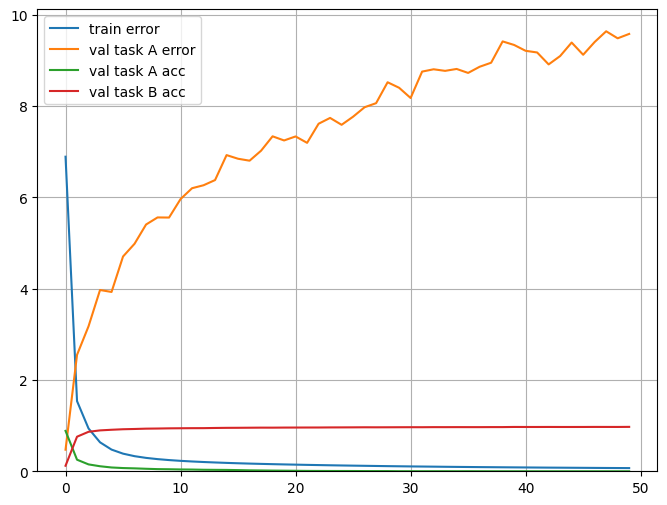

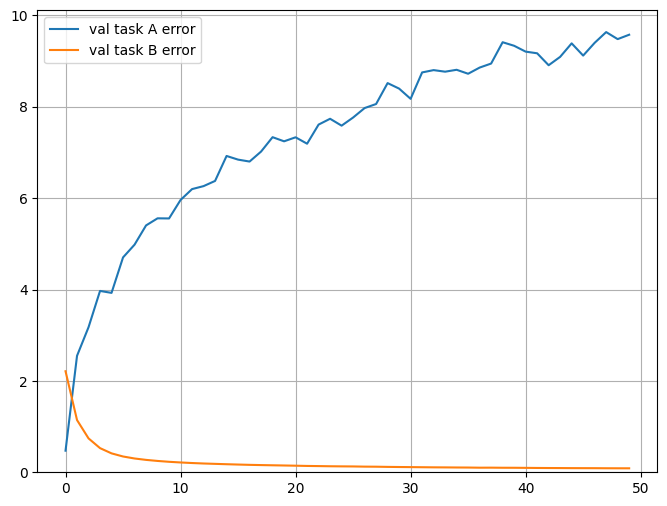

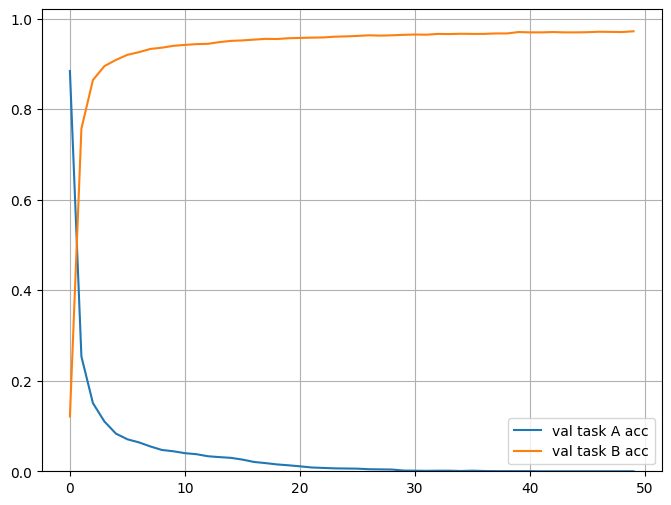

In [11]:
plt.figure(figsize=(8,6))
plt.plot(range(len(train_loss_list)), [l.cpu() for l in train_loss_list], label="train error")
plt.plot(range(0, validation_freq*len(val_A_loss_list), validation_freq), [l.cpu() for l in val_A_loss_list], label="val task A error")
plt.plot(range(0, validation_freq*len(val_A_acc_list), validation_freq), [l.cpu() for l in val_A_acc_list], label="val task A acc")
plt.plot(range(0, validation_freq*len(val_B_acc_list), validation_freq), [l.cpu() for l in val_B_acc_list], label="val task B acc")
#plt.plot(range(0, validation_freq*len(val_B_loss_list), validation_freq), [l.cpu() for l in val_B_loss_list], label="val task B error")
plt.legend()
plt.grid(True)
plt.ylim(bottom=0)
plt.show()

plt.figure(figsize=(8,6))
plt.plot(range(0, validation_freq*len(val_A_loss_list), validation_freq), [l.cpu() for l in val_A_loss_list], label="val task A error")
plt.plot(range(0, validation_freq*len(val_B_loss_list), validation_freq), [l.cpu() for l in val_B_loss_list], label="val task B error")
plt.legend()
plt.grid(True)
plt.ylim(bottom=0)
plt.show()

plt.figure(figsize=(8,6))
plt.plot(range(0, validation_freq*len(val_A_acc_list), validation_freq), [l.cpu() for l in val_A_acc_list], label="val task A acc")
plt.plot(range(0, validation_freq*len(val_B_acc_list), validation_freq), [l.cpu() for l in val_B_acc_list], label="val task B acc")
plt.legend()
plt.grid(True)
plt.ylim(bottom=0)
plt.show()

¡UPS!

Parece que hemos entrenado el modelo para la tarea B con mucho éxito... al coste de que sea incapaz de resolver la tarea A. Este problema es lo que se conoce como el Olvido Catastrófico (*Catastrophic Forgetting*). Si lo reflexionamos... es lo esperable. Aprender para una red neuronal es ajustar los pesos para minimizar el error de los datos. Si cambias los datos, el ajuste de los pesos ya no tiende a funcionar bien con los datos anteriores.

El Aprendizaje Continuo (*Continual learning*) es un enfoque en el que se pretende que un modelo neuronal aprenda secuencialmente distintas tareas SIN olvidar las anteriores. Esto se puede diferenciar en tres escenarios típicos distintos:

 * Task-Incremental Learning: Añadimos al modelo nuevas tareas claramente diferenciadas y le proveemos información sobre cuándo está realizando una u otra. Por ejemplo: primero aprender a clasificar MNIST y luego Fashion-MNIST. En este caso las tareas, aunque consistentes ambas en clasificar imágenes, están separadas. La misma red es capaz de funcionar bien para ambos problemas, pero los problemas no se mezclan.
 * Domain-Incremental Learning: Cambia la distribución de datos sobre la que aprender, aunque las etiquetas para aprender son las mismas Ejemplo: hacer que un modelo reconozca fotos de chihuahuas con la etiqueta "perro" sin olvidar que un terrier también lo es.
 * Class-Incremental learning: Se añaden nuevas etiquetas al modelo que antes no aparecían o tenían poco peso. Ejemplo: que un modelo que clasifica gatos, zorros y gatos también clasifique conejos, liberes y coballas.

 En este caso estamos planteando un ejemplo del tercer tipo. Ahora la cuestión es... ¿cómo evitamos el olvido catastrófico? No es trivial y es un campo de investigación abierto, pero vamos a ver dos técnicas.

## Guardamos algunos ejemplos de las tareas anteriores

No queremos tener que usar todo el conjunto de datos de la Tarea A para entrenar la Tarea B, pero usar solo una pequeña parte puede tener beneficios.

Vamos a quedarnos con un 10% del conjunto de datos de la Tarea A. En esta implementación no estamos atendiendo al balanceo de las clases, aunque lo ideal sería quedarnos con un 10% de los datos que representara cada clase de manera balanceada. Por simplicidad, confiamos en la estadistica para que haga el balanceo.

In [12]:
_, little_bit_of_train_dataset_A = split_dataset(train_dataset_A, split_share = 0.9)

train_dataset_B_with_a_little_bit_of_task_A = ConcatDataset([train_dataset_B, little_bit_of_train_dataset_A])

train_dataloader_B_with_a_little_bit_of_task_A = DataLoader(train_dataset_B_with_a_little_bit_of_task_A, batch_size=batch_size, shuffle=True)

Tras crear un conjunto de datos que incluye los de la tarea B y un 10% de los datos de la tarea A, vamos a volver a hacer el experimento. Entrenamos el modelo para la tarea A...

In [13]:
torch.manual_seed(0)

model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(28*28,64),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(64,10)
).to(device)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate
  )

model, train_loss_list, val_A_loss_list, val_A_acc_list, val_B_loss_list, val_B_acc_list = learning_loop_for_classification_with_two_tasks(
    train_dataloader_A,
    val_dataloader_A,
    val_dataloader_B,
    model,
    epochs,
    loss_fn,
    optimizer,
    validation_freq = validation_freq)

print(f"Número de parámetros {torch.tensor([p.numel() for p in model.parameters()]).sum()}")

epoch:: 100%|██████████| 50/50 [00:06<00:00,  8.23it/s, loss=0.021537993103265762]

Número de parámetros 50890


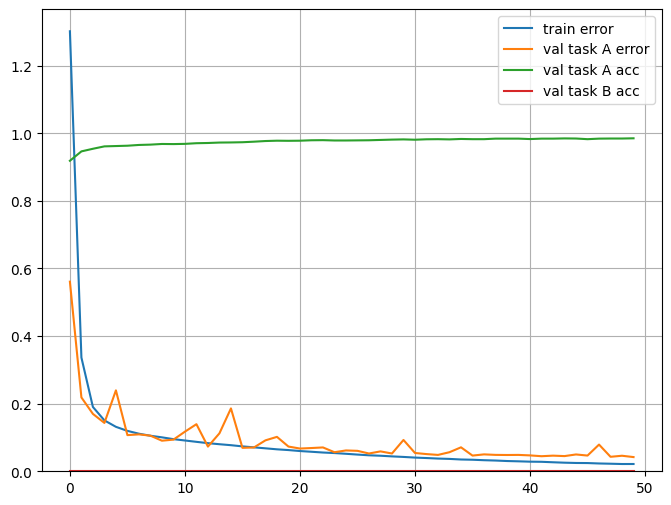

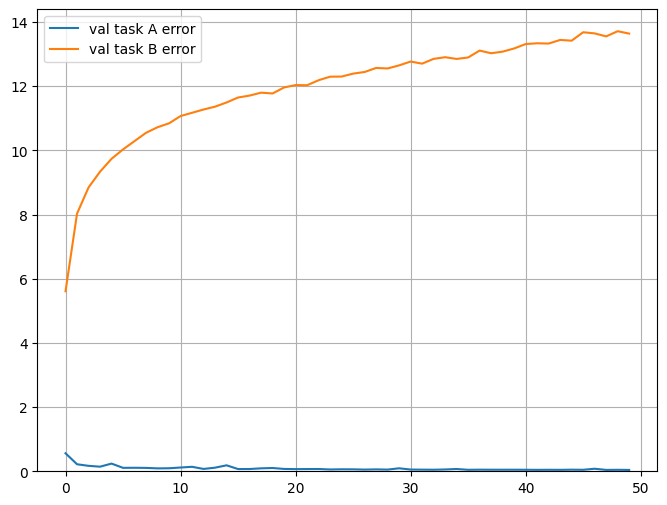

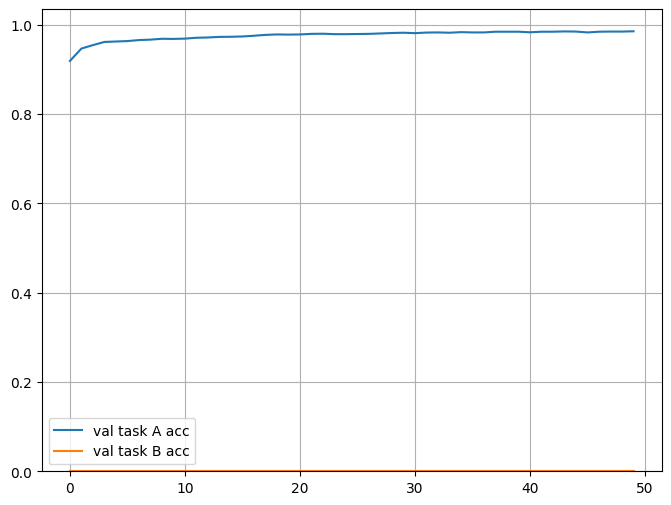

In [14]:
plt.figure(figsize=(8,6))
plt.plot(range(len(train_loss_list)), [l.cpu() for l in train_loss_list], label="train error")
plt.plot(range(0, validation_freq*len(val_A_loss_list), validation_freq), [l.cpu() for l in val_A_loss_list], label="val task A error")
plt.plot(range(0, validation_freq*len(val_A_acc_list), validation_freq), [l.cpu() for l in val_A_acc_list], label="val task A acc")
plt.plot(range(0, validation_freq*len(val_B_acc_list), validation_freq), [l.cpu() for l in val_B_acc_list], label="val task B acc")
#plt.plot(range(0, validation_freq*len(val_B_loss_list), validation_freq), [l.cpu() for l in val_B_loss_list], label="val task B error")
plt.legend()
plt.grid(True)
plt.ylim(bottom=0)
plt.show()

plt.figure(figsize=(8,6))
plt.plot(range(0, validation_freq*len(val_A_loss_list), validation_freq), [l.cpu() for l in val_A_loss_list], label="val task A error")
plt.plot(range(0, validation_freq*len(val_B_loss_list), validation_freq), [l.cpu() for l in val_B_loss_list], label="val task B error")
plt.legend()
plt.grid(True)
plt.ylim(bottom=0)
plt.show()

plt.figure(figsize=(8,6))
plt.plot(range(0, validation_freq*len(val_A_acc_list), validation_freq), [l.cpu() for l in val_A_acc_list], label="val task A acc")
plt.plot(range(0, validation_freq*len(val_B_acc_list), validation_freq), [l.cpu() for l in val_B_acc_list], label="val task B acc")
plt.legend()
plt.grid(True)
plt.ylim(bottom=0)
plt.show()

Y ahora entrenamos el modelo para la tarea B con algunos datos que le recuerden la A.

In [15]:
torch.manual_seed(0)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate
  )

model, train_loss_list, val_A_loss_list, val_A_acc_list, val_B_loss_list, val_B_acc_list = learning_loop_for_classification_with_two_tasks(
    train_dataloader_B_with_a_little_bit_of_task_A,
    val_dataloader_A,
    val_dataloader_B,
    model,
    epochs,
    loss_fn,
    optimizer,
    validation_freq = validation_freq)

print(f"Número de parámetros {torch.tensor([p.numel() for p in model.parameters()]).sum()}")

epoch:: 100%|██████████| 50/50 [00:07<00:00,  7.05it/s, loss=0.09105731546878815]

Número de parámetros 50890


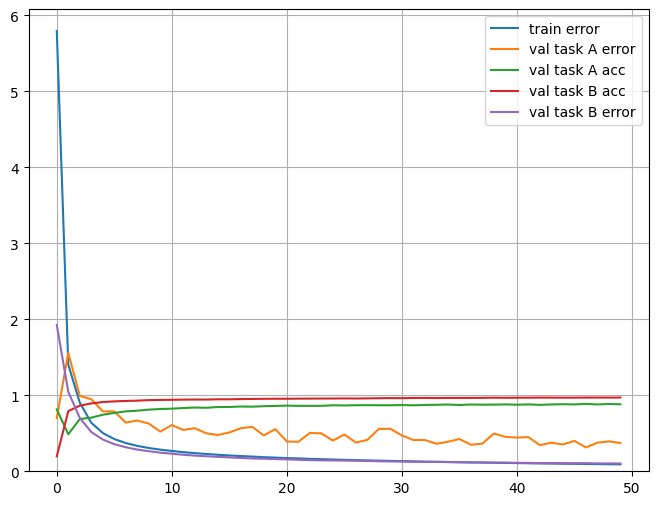

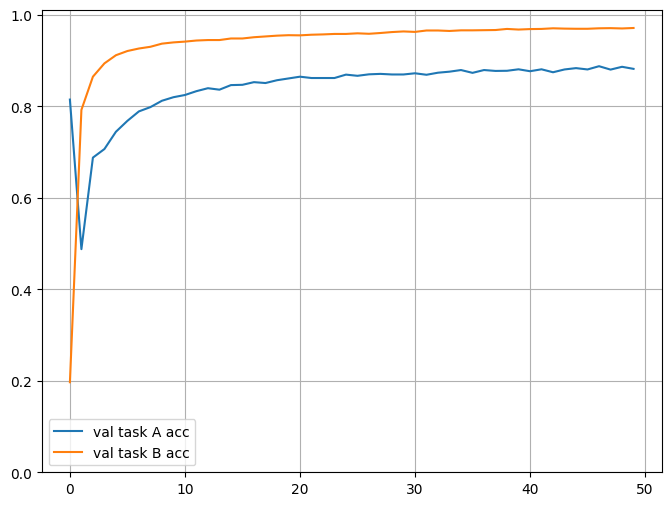

In [16]:
plt.figure(figsize=(8,6))
plt.plot(range(len(train_loss_list)), [l.cpu() for l in train_loss_list], label="train error")
plt.plot(range(0, validation_freq*len(val_A_loss_list), validation_freq), [l.cpu() for l in val_A_loss_list], label="val task A error")
plt.plot(range(0, validation_freq*len(val_A_acc_list), validation_freq), [l.cpu() for l in val_A_acc_list], label="val task A acc")
plt.plot(range(0, validation_freq*len(val_B_acc_list), validation_freq), [l.cpu() for l in val_B_acc_list], label="val task B acc")
plt.plot(range(0, validation_freq*len(val_B_loss_list), validation_freq), [l.cpu() for l in val_B_loss_list], label="val task B error")
plt.legend()
plt.grid(True)
plt.ylim(bottom=0)
plt.show()

plt.figure(figsize=(8,6))
plt.plot(range(0, validation_freq*len(val_A_acc_list), validation_freq), [l.cpu() for l in val_A_acc_list], label="val task A acc")
plt.plot(range(0, validation_freq*len(val_B_acc_list), validation_freq), [l.cpu() for l in val_B_acc_list], label="val task B acc")
plt.legend()
plt.grid(True)
plt.ylim(bottom=0)
plt.show()

Y... parece que el resultado es mucho mejor. El modelo resultante pierde capacidad en la tarea A, pero es también capaz de reralizar la B. Sin embargo, si nos fijamos en el error de validación y el accuracy para la tarea A, podemos deducir que el modelo comienza "olvidando" sensiblemente la tarea A (su acc baja hasta 0.5) mientras se ajusta a la tarea B y luego vuelve a mejorar en la tarea A gracias a los datos que tiene.

Vamos a ver qué ocurre si solo añadimos un 1% de los datos de la tarea A.

In [17]:
_, little_bit_of_train_dataset_A = split_dataset(train_dataset_A, split_share = 0.99)

train_dataset_B_with_a_little_bit_of_task_A = ConcatDataset([train_dataset_B, little_bit_of_train_dataset_A])

train_dataloader_B_with_a_little_bit_of_task_A = DataLoader(train_dataset_B_with_a_little_bit_of_task_A, batch_size=batch_size, shuffle=True)

In [18]:
torch.manual_seed(0)

model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(28*28,64),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(64,10)
).to(device)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate
  )

model, train_loss_list, val_A_loss_list, val_A_acc_list, val_B_loss_list, val_B_acc_list = learning_loop_for_classification_with_two_tasks(
    train_dataloader_A,
    val_dataloader_A,
    val_dataloader_B,
    model,
    epochs,
    loss_fn,
    optimizer,
    validation_freq = validation_freq)

print(f"Número de parámetros {torch.tensor([p.numel() for p in model.parameters()]).sum()}")

epoch:: 100%|██████████| 50/50 [00:06<00:00,  7.98it/s, loss=0.021537993103265762]

Número de parámetros 50890


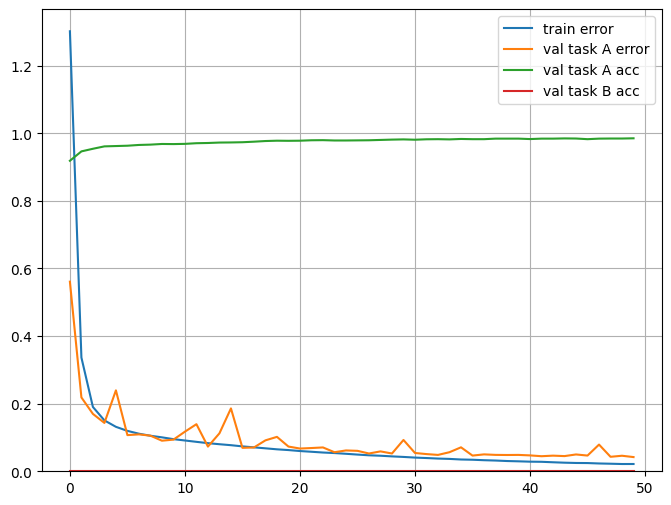

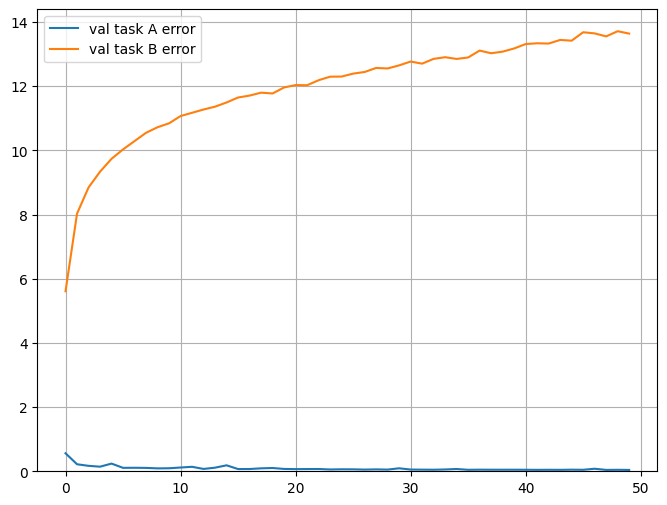

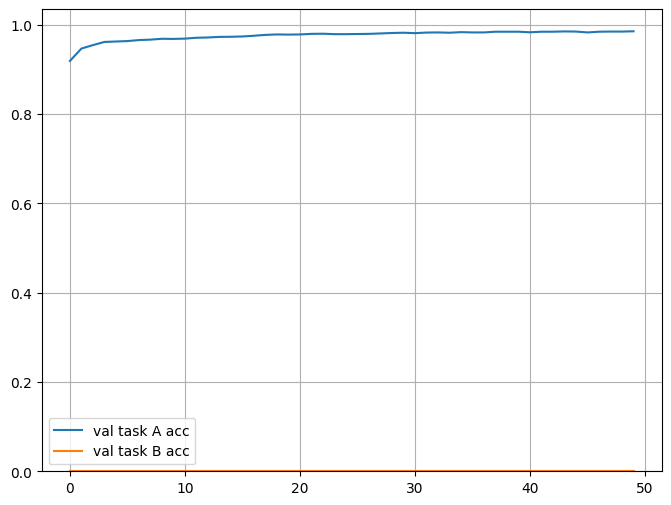

In [19]:
plt.figure(figsize=(8,6))
plt.plot(range(len(train_loss_list)), [l.cpu() for l in train_loss_list], label="train error")
plt.plot(range(0, validation_freq*len(val_A_loss_list), validation_freq), [l.cpu() for l in val_A_loss_list], label="val task A error")
plt.plot(range(0, validation_freq*len(val_A_acc_list), validation_freq), [l.cpu() for l in val_A_acc_list], label="val task A acc")
plt.plot(range(0, validation_freq*len(val_B_acc_list), validation_freq), [l.cpu() for l in val_B_acc_list], label="val task B acc")
#plt.plot(range(0, validation_freq*len(val_B_loss_list), validation_freq), [l.cpu() for l in val_B_loss_list], label="val task B error")
plt.legend()
plt.grid(True)
plt.ylim(bottom=0)
plt.show()

plt.figure(figsize=(8,6))
plt.plot(range(0, validation_freq*len(val_A_loss_list), validation_freq), [l.cpu() for l in val_A_loss_list], label="val task A error")
plt.plot(range(0, validation_freq*len(val_B_loss_list), validation_freq), [l.cpu() for l in val_B_loss_list], label="val task B error")
plt.legend()
plt.grid(True)
plt.ylim(bottom=0)
plt.show()

plt.figure(figsize=(8,6))
plt.plot(range(0, validation_freq*len(val_A_acc_list), validation_freq), [l.cpu() for l in val_A_acc_list], label="val task A acc")
plt.plot(range(0, validation_freq*len(val_B_acc_list), validation_freq), [l.cpu() for l in val_B_acc_list], label="val task B acc")
plt.legend()
plt.grid(True)
plt.ylim(bottom=0)
plt.show()

In [20]:
torch.manual_seed(0)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate
  )

model, train_loss_list, val_A_loss_list, val_A_acc_list, val_B_loss_list, val_B_acc_list = learning_loop_for_classification_with_two_tasks(
    train_dataloader_B_with_a_little_bit_of_task_A,
    val_dataloader_A,
    val_dataloader_B,
    model,
    epochs,
    loss_fn,
    optimizer,
    validation_freq = validation_freq)

print(f"Número de parámetros {torch.tensor([p.numel() for p in model.parameters()]).sum()}")

epoch:: 100%|██████████| 50/50 [00:06<00:00,  7.67it/s, loss=0.07589586824178696]

Número de parámetros 50890


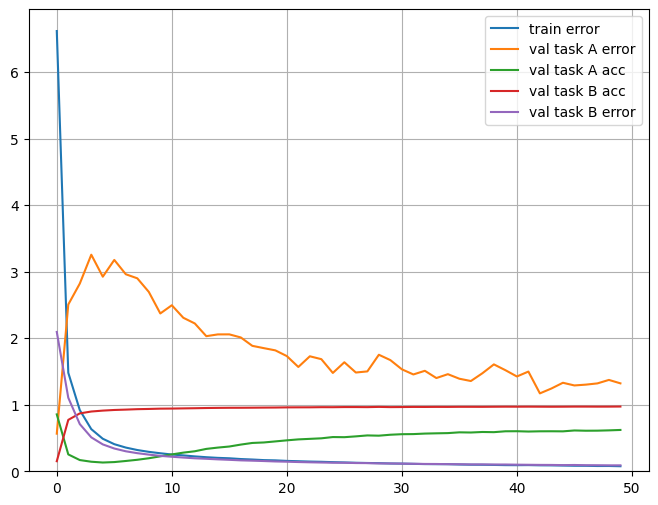

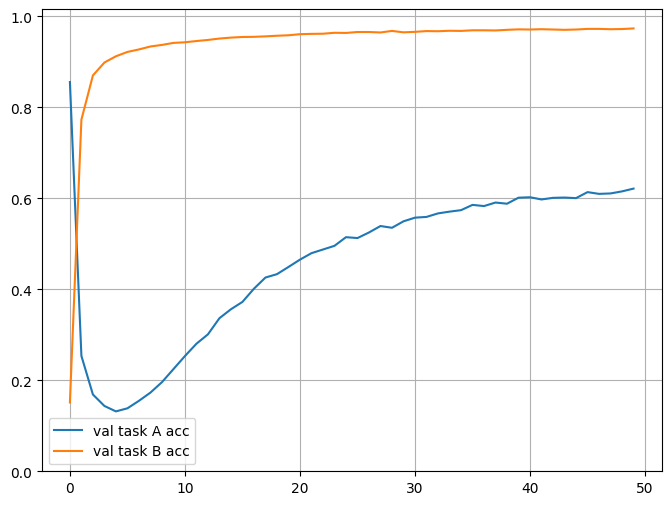

In [21]:
plt.figure(figsize=(8,6))
plt.plot(range(len(train_loss_list)), [l.cpu() for l in train_loss_list], label="train error")
plt.plot(range(0, validation_freq*len(val_A_loss_list), validation_freq), [l.cpu() for l in val_A_loss_list], label="val task A error")
plt.plot(range(0, validation_freq*len(val_A_acc_list), validation_freq), [l.cpu() for l in val_A_acc_list], label="val task A acc")
plt.plot(range(0, validation_freq*len(val_B_acc_list), validation_freq), [l.cpu() for l in val_B_acc_list], label="val task B acc")
plt.plot(range(0, validation_freq*len(val_B_loss_list), validation_freq), [l.cpu() for l in val_B_loss_list], label="val task B error")
plt.legend()
plt.grid(True)
plt.ylim(bottom=0)
plt.show()

plt.figure(figsize=(8,6))
plt.plot(range(0, validation_freq*len(val_A_acc_list), validation_freq), [l.cpu() for l in val_A_acc_list], label="val task A acc")
plt.plot(range(0, validation_freq*len(val_B_acc_list), validation_freq), [l.cpu() for l in val_B_acc_list], label="val task B acc")
plt.legend()
plt.grid(True)
plt.ylim(bottom=0)
plt.show()

Esta vez lo vemos de forma mucho más clara. El modelo se está ajustando a la tarea B (la que resulta más "rentable" optimizar para minimizar el gradiente medio) y, cuando ya funciona razonablemente bien para la tarea B, empieza a mejorar para la tarea A.

¿Es esto evitar el olvido catastrófico? Técnicamente, sí, pero ¿qué tal funcionaría un modelo entrenado de 0 con los datos de la tarea B y el 1% de los datos de la tarea A?

In [22]:
torch.manual_seed(0)

model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(28*28,64),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(64,10)
).to(device)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate
  )

model, train_loss_list, val_A_loss_list, val_A_acc_list, val_B_loss_list, val_B_acc_list = learning_loop_for_classification_with_two_tasks(
    train_dataloader_B_with_a_little_bit_of_task_A,
    val_dataloader_A,
    val_dataloader_B,
    model,
    epochs,
    loss_fn,
    optimizer,
    validation_freq = validation_freq)

print(f"Número de parámetros {torch.tensor([p.numel() for p in model.parameters()]).sum()}")

epoch:: 100%|██████████| 50/50 [00:06<00:00,  7.53it/s, loss=0.040381722152233124]

Número de parámetros 50890


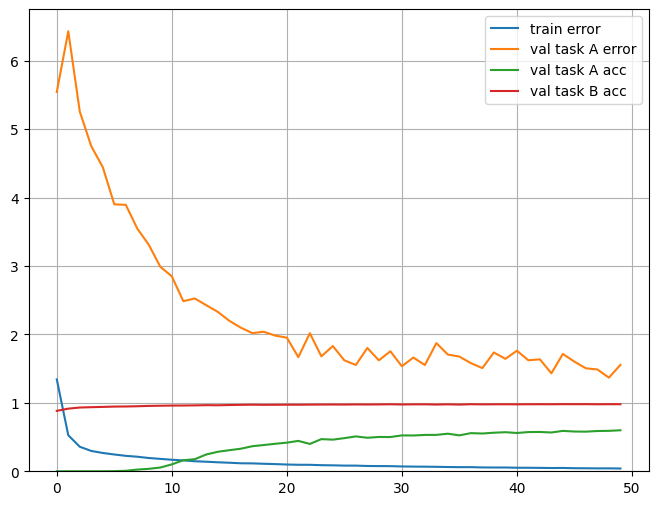

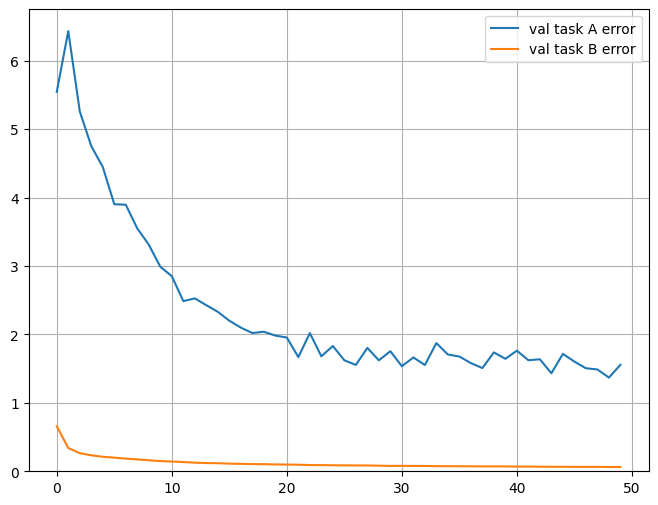

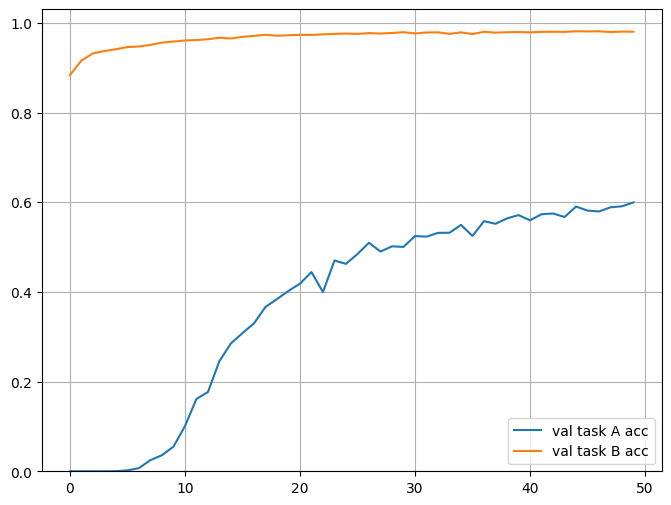

In [23]:
plt.figure(figsize=(8,6))
plt.plot(range(len(train_loss_list)), [l.cpu() for l in train_loss_list], label="train error")
plt.plot(range(0, validation_freq*len(val_A_loss_list), validation_freq), [l.cpu() for l in val_A_loss_list], label="val task A error")
plt.plot(range(0, validation_freq*len(val_A_acc_list), validation_freq), [l.cpu() for l in val_A_acc_list], label="val task A acc")
plt.plot(range(0, validation_freq*len(val_B_acc_list), validation_freq), [l.cpu() for l in val_B_acc_list], label="val task B acc")
#plt.plot(range(0, validation_freq*len(val_B_loss_list), validation_freq), [l.cpu() for l in val_B_loss_list], label="val task B error")
plt.legend()
plt.grid(True)
plt.ylim(bottom=0)
plt.show()

plt.figure(figsize=(8,6))
plt.plot(range(0, validation_freq*len(val_A_loss_list), validation_freq), [l.cpu() for l in val_A_loss_list], label="val task A error")
plt.plot(range(0, validation_freq*len(val_B_loss_list), validation_freq), [l.cpu() for l in val_B_loss_list], label="val task B error")
plt.legend()
plt.grid(True)
plt.ylim(bottom=0)
plt.show()

plt.figure(figsize=(8,6))
plt.plot(range(0, validation_freq*len(val_A_acc_list), validation_freq), [l.cpu() for l in val_A_acc_list], label="val task A acc")
plt.plot(range(0, validation_freq*len(val_B_acc_list), validation_freq), [l.cpu() for l in val_B_acc_list], label="val task B acc")
plt.legend()
plt.grid(True)
plt.ylim(bottom=0)
plt.show()

Lo cierto es que los resultados no son muy distintos al entrenamiento secuencial. ¿Quiere decir esto que el entrenamiento secuencial no es rentable? Depende del caso. En este claramente no, pero en problemas máscomplejos con redes más costosas de entrenar y más tareas la diferencia sí puede ser apreciable.

## Regularizamos en función a la importancia de los pesos

Antes lo hemos intentado resolver desde el punto de vista de los datos, pero... ¿y si nos centramos en los pesos? 

Dada una estimación de probabilidad que depende de unos parámetros $\theta$, podemos calcular la importancia de los parámetros $\theta_{i}$ para el resultado de la probabilidad con la matriz de Fisher, que se define como sigue:

$$F_{i,j} = \mathbb{E}_{x\sim D} [\frac{\partial log(p(x | \theta))}{\partial \theta_{i}} \frac{\partial log(p(x | \theta))}{\partial \theta_{j}}]$$

Siendo $D$ un conjunto de datos.

No vamos a entrar en la demostración de la matriz de Fisher, sino en cómo nos puede ayudar. El método *Elastic Weight Consolidation* (EWC) utiliza la matriz de Fisher para intentar evitar el olvido catastrófico. La idea es sencilla: una vez entrenado un modelo para la tarea A con el conjunto de datos $C_{A}$, medir cómo de importante es cada peso para el cálculo de las probabilidades. ¿Problema? Que la matriz de Fisher calcula la relación entre pesos. Si trabajamos con 100 pesos, la matriz tiene tamaño 100x100. Si trabajamos con varios millones de pesos... La matriz se vuelve intratable. Por eso EWC no calcula la matriz completa, sino la diagonal como sigue:

$$F_{i} = \mathbb{E}_{x\in C_{A}} [(\frac{\partial log(p(x | \theta))}{\partial \theta_{i}})^2]$$

Nótse que ese $p(x|\theta)$ se traduce en la probabilidad extraída del modelo en base a los pesos $\theta$.

¿Qué quiere decir esto? Que basicamente debemos promediar el cuadrado del gradiente para todos los ejemplos del conjunto $C_{A}$. Una suerte que tengamos una herramienta excelente para calcular derivadas parciales.

Una vez calculada la diagonal de Fisher, podemos definir una regularización como la que sigue:

$$L_{EWC} = \sum_{\theta_{i}\in \theta} F_{i}(\theta_{i}-\theta_{A,i})^2$$

Siendo $\theta_{A}$ los pesos del modelo tras entrenarlo para la tarea A. Básicamente el regularizador penaliza que los pesos cambien cuanto más importantes eran para clasificar en la tarea A. El problema es que contemplar solo la diagonal de la matriz implica que solo estamos comprobando la relevancia de cada peso independiente de los demás. ¡No tenemos en cuenta la importancia que varios pesos pueden tener en conjunto!

¡Vamos a probarlo!

In [24]:
def compute_fisher(model, dataloader):
    model.eval()
    fisher = {n: torch.zeros_like(p) for n, p in model.named_parameters()}

    for data, target in dataloader:
        model.zero_grad()
        output = model(data)
        loss = nn.functional.nll_loss(
            nn.functional.log_softmax(output, dim=-1),
            target
        )
        loss.backward()

        # Calculo el valor de la matriz para cada parámetro. 
        for (n, p) in model.named_parameters():
            fisher[n] += p.grad.data**2

    for n in fisher:
        fisher[n] /= len(dataloader) # Termino de hacer la media.
        fisher[n] /= (fisher[n].max() + 1e-8) # Normalizo para que los valores de importancia más altos sean cercanos a 1.

    return fisher

class EWC_Reg:
    def __init__(self, model, dataloader):
        self.model = model
        self.params = {n: p.clone().detach() for n, p in model.named_parameters()}
        self.fisher = compute_fisher(model, dataloader)

        #for k, v in self.fisher.items():
        #  print(k, v.mean().item(), v.max().item())

    def penalty(self, model):
        loss = 0
        for (n, p) in model.named_parameters():
            loss += (self.fisher[n] * (p - self.params[n])**2).sum()
        return  loss

In [25]:
def learning_loop_for_classification_with_two_tasks_and_EWC(train_dataloader, val_dataloader_task_A, val_dataloader_task_B, model, epochs, loss_fn, ewc, alpha_ewc, optimizer, validation_freq):
  epoch_loss_list = []
  val_A_loss_list = []
  val_A_acc_list = []
  val_B_loss_list = []
  val_B_acc_list = []
  EWC_loss_list = []
  classification_loss_list = []

  with tqdm(range(epochs), desc="epoch:") as pbar:
    for epoch in pbar:
      model.train()
      steps_loss_list = []
      steps_classification_loss_list = []
      steps_EWC_loss_list = []

      for x_true, y_true in train_dataloader:
        y_pred = model(x_true)                              # Forward
        optimizer.zero_grad()

        classification_loss = loss_fn(y_pred, y_true)
        ewc_loss = ewc.penalty(model)
        total_loss = classification_loss + alpha_ewc * ewc_loss

        total_loss.backward()                                     # Backward

        steps_loss_list.append(total_loss.clone().detach())
        steps_classification_loss_list.append(classification_loss.clone().detach())
        steps_EWC_loss_list.append(ewc_loss.clone().detach())

        optimizer.step()
      train_loss = torch.tensor(steps_loss_list).mean()
      epoch_loss_list.append(train_loss)
      pbar.set_postfix(loss=f"{train_loss}")

      classification_loss = torch.tensor(steps_classification_loss_list).mean()
      classification_loss_list.append(classification_loss)
      EWC_loss = torch.tensor(steps_EWC_loss_list).mean()
      EWC_loss_list.append(EWC_loss)

      if epoch%validation_freq==0:
          model.eval()
          val_A_loss, val_A_correct_answers, val_A_set_size = val_epoch(val_dataloader_task_A, model, loss_fn)
          val_A_loss_list.append(val_A_loss)
          val_A_acc_list.append(val_A_correct_answers/float(val_A_set_size))

          val_B_loss, val_B_correct_answers, val_B_set_size = val_epoch(val_dataloader_task_B, model, loss_fn)
          val_B_loss_list.append(val_B_loss)
          val_B_acc_list.append(val_B_correct_answers/float(val_B_set_size))

  return model, epoch_loss_list, classification_loss_list, EWC_loss_list, val_A_loss_list, val_A_acc_list, val_B_loss_list, val_B_acc_list

Una vez definida una clase que se ocupe de calcular la diagonal de Fisher y el valor del regularizador, vamos a entrenar oootro modelo para la tarea A.

In [26]:
torch.manual_seed(0)

model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(28*28,256),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(256,10)
).to(device)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate
  )

model, train_loss_list, val_A_loss_list, val_A_acc_list, val_B_loss_list, val_B_acc_list = learning_loop_for_classification_with_two_tasks(
    train_dataloader_A,
    val_dataloader_A,
    val_dataloader_B,
    model,
    epochs,
    loss_fn,
    optimizer,
    validation_freq = validation_freq)

print(f"Número de parámetros {torch.tensor([p.numel() for p in model.parameters()]).sum()}")

epoch:: 100%|██████████| 50/50 [00:06<00:00,  8.16it/s, loss=0.0030360622331500053]

Número de parámetros 203530


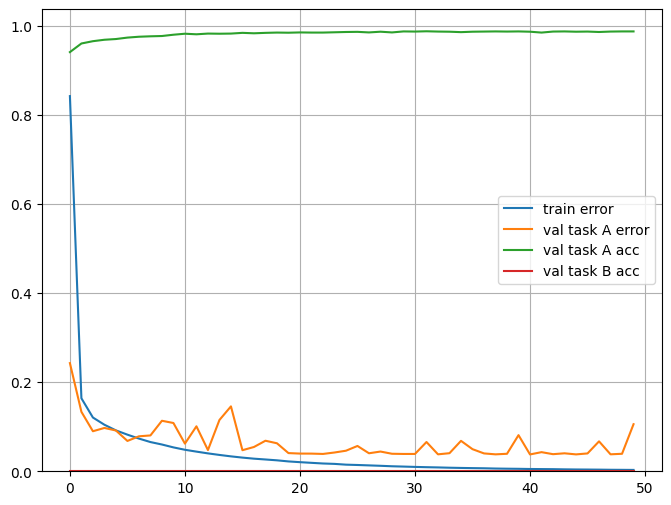

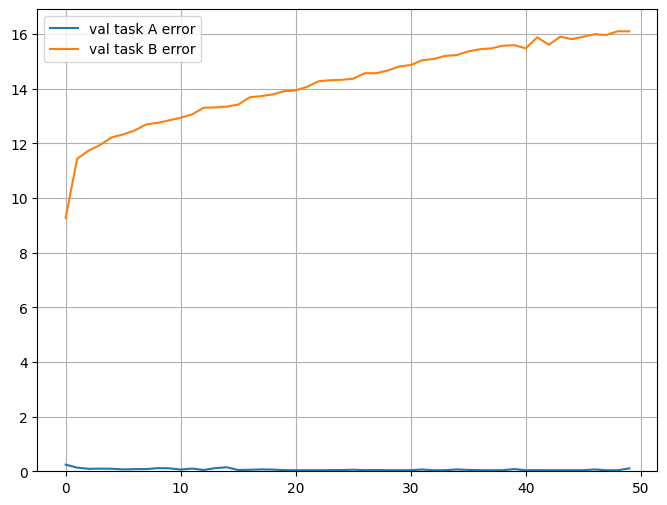

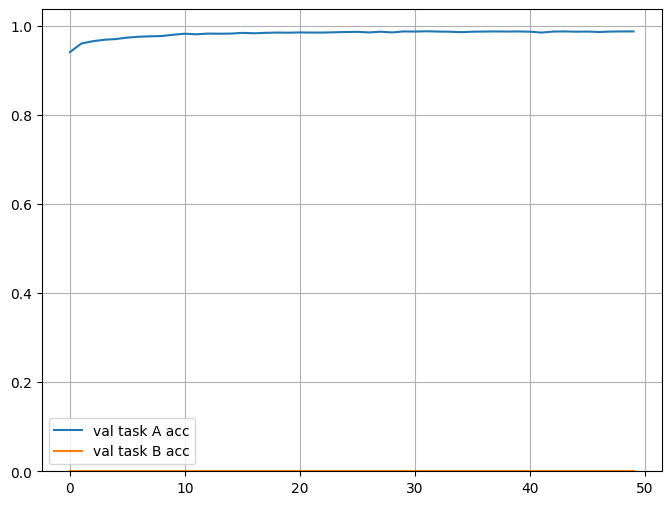

In [27]:
plt.figure(figsize=(8,6))
plt.plot(range(len(train_loss_list)), [l.cpu() for l in train_loss_list], label="train error")
plt.plot(range(0, validation_freq*len(val_A_loss_list), validation_freq), [l.cpu() for l in val_A_loss_list], label="val task A error")
plt.plot(range(0, validation_freq*len(val_A_acc_list), validation_freq), [l.cpu() for l in val_A_acc_list], label="val task A acc")
plt.plot(range(0, validation_freq*len(val_B_acc_list), validation_freq), [l.cpu() for l in val_B_acc_list], label="val task B acc")
#plt.plot(range(0, validation_freq*len(val_B_loss_list), validation_freq), [l.cpu() for l in val_B_loss_list], label="val task B error")
plt.legend()
plt.grid(True)
plt.ylim(bottom=0)
plt.show()

plt.figure(figsize=(8,6))
plt.plot(range(0, validation_freq*len(val_A_loss_list), validation_freq), [l.cpu() for l in val_A_loss_list], label="val task A error")
plt.plot(range(0, validation_freq*len(val_B_loss_list), validation_freq), [l.cpu() for l in val_B_loss_list], label="val task B error")
plt.legend()
plt.grid(True)
plt.ylim(bottom=0)
plt.show()

plt.figure(figsize=(8,6))
plt.plot(range(0, validation_freq*len(val_A_acc_list), validation_freq), [l.cpu() for l in val_A_acc_list], label="val task A acc")
plt.plot(range(0, validation_freq*len(val_B_acc_list), validation_freq), [l.cpu() for l in val_B_acc_list], label="val task B acc")
plt.legend()
plt.grid(True)
plt.ylim(bottom=0)
plt.show()

Ahora que tenemos un modelo entrenado para la tarea A, necesitamos calcular la matriz de Fisher. Nuestra clase EWC_Reg se encargará, pero es importante recordar que tiene que calcular la derivada parcial para cada ejemplo. No para lotes. Para cada ejemplo. Por eso vamos a definir un dataloader con tamaño de *batch* 1. Vamos a usar el conjunto de validación para evitar los sesgos de un hipotético sobreentrenamiento.

In [28]:
torch.manual_seed(0)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate
  )

val_dataloader_A_for_EWC = DataLoader(val_dataset_A, batch_size=1, shuffle=True)

EWC = EWC_Reg(model, val_dataloader_A_for_EWC)
EWC_alpha = 100000000

model, epoch_loss_list, classification_loss_list, EWC_loss_list, val_A_loss_list, val_A_acc_list, val_B_loss_list, val_B_acc_list = learning_loop_for_classification_with_two_tasks_and_EWC(
    train_dataloader_B,
    val_dataloader_A,
    val_dataloader_B,
    model,
    epochs,
    loss_fn,
    EWC,
    EWC_alpha,
    optimizer,
    validation_freq = validation_freq)

print(f"Número de parámetros {torch.tensor([p.numel() for p in model.parameters()]).sum()}")

epoch:: 100%|██████████| 50/50 [00:06<00:00,  7.28it/s, loss=2.4913330078125]   

Número de parámetros 203530


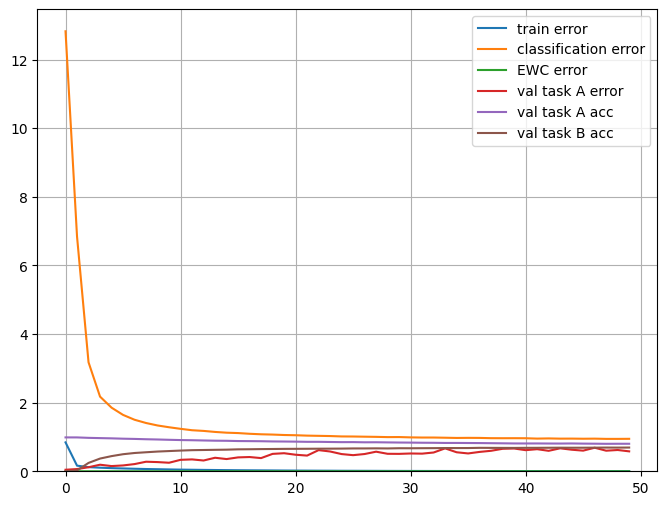

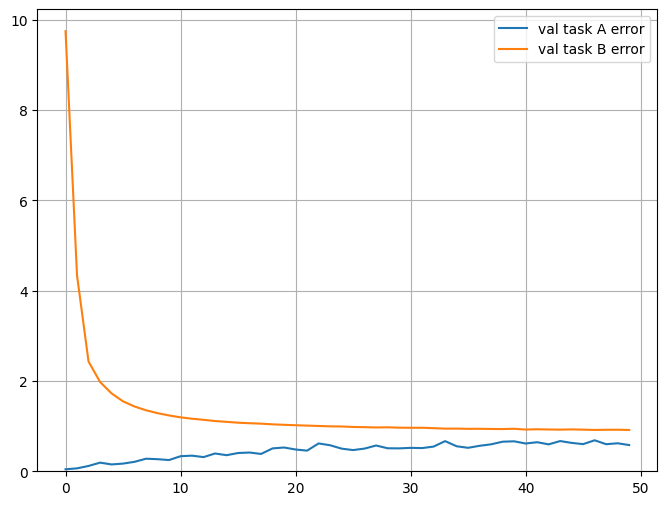

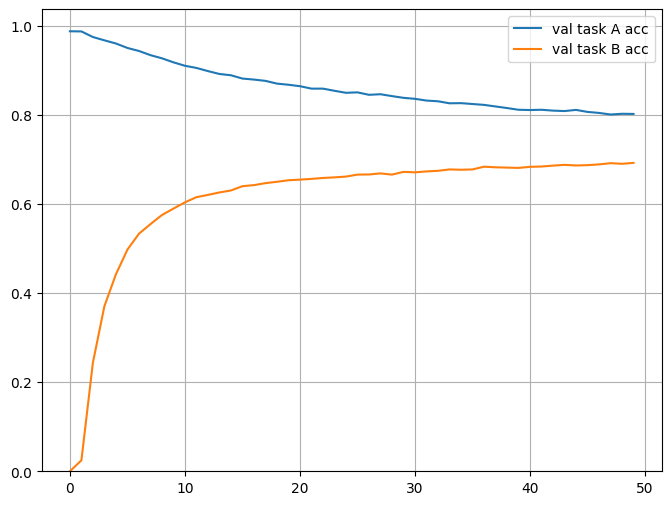

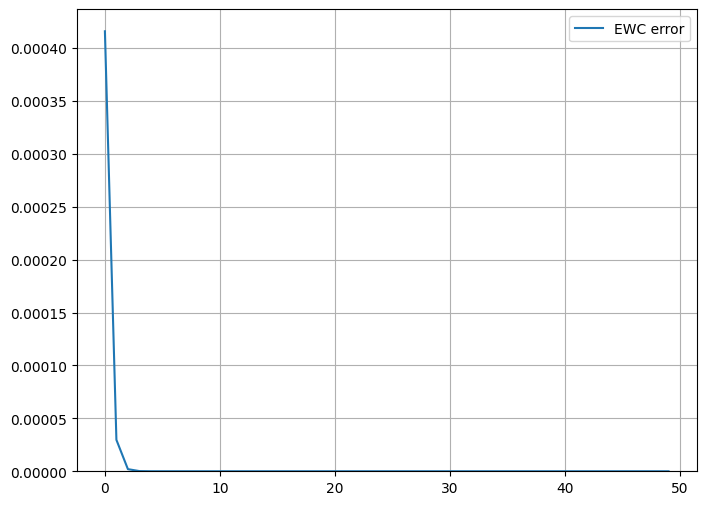

In [29]:
plt.figure(figsize=(8,6))
plt.plot(range(len(train_loss_list)), [l.cpu() for l in train_loss_list], label="train error")
plt.plot(range(len(classification_loss_list)), [l.cpu() for l in classification_loss_list], label="classification error")
plt.plot(range(len(EWC_loss_list)), [l.cpu() for l in EWC_loss_list], label="EWC error")
plt.plot(range(0, validation_freq*len(val_A_loss_list), validation_freq), [l.cpu() for l in val_A_loss_list], label="val task A error")
plt.plot(range(0, validation_freq*len(val_A_acc_list), validation_freq), [l.cpu() for l in val_A_acc_list], label="val task A acc")
plt.plot(range(0, validation_freq*len(val_B_acc_list), validation_freq), [l.cpu() for l in val_B_acc_list], label="val task B acc")
#plt.plot(range(0, validation_freq*len(val_B_loss_list), validation_freq), [l.cpu() for l in val_B_loss_list], label="val task B error")
plt.legend()
plt.grid(True)
plt.ylim(bottom=0)
plt.show()

plt.figure(figsize=(8,6))
plt.plot(range(0, validation_freq*len(val_A_loss_list), validation_freq), [l.cpu() for l in val_A_loss_list], label="val task A error")
plt.plot(range(0, validation_freq*len(val_B_loss_list), validation_freq), [l.cpu() for l in val_B_loss_list], label="val task B error")
plt.legend()
plt.grid(True)
plt.ylim(bottom=0)
plt.show()

plt.figure(figsize=(8,6))
plt.plot(range(0, validation_freq*len(val_A_acc_list), validation_freq), [l.cpu() for l in val_A_acc_list], label="val task A acc")
plt.plot(range(0, validation_freq*len(val_B_acc_list), validation_freq), [l.cpu() for l in val_B_acc_list], label="val task B acc")
plt.legend()
plt.grid(True)
plt.ylim(bottom=0)
plt.show()

plt.figure(figsize=(8,6))
plt.plot(range(len(EWC_loss_list)), [l.cpu() for l in EWC_loss_list], label="EWC error")
plt.legend()
plt.grid(True)
plt.ylim(bottom=0)
plt.show()

No hace maravillas, pero resulta interesante ver que si sigue así habrá un "punto dulce" en el que la tarea A y B tengan a la vez casi un 80% de precisión. Nótese que en el error de validación para la tarea A y B no se incluye el regularizador (porque no forma parte de las tareas).

Antes de terminar, vamos a probar a combinar las dos técnicas que hemos visto.

In [30]:
torch.manual_seed(0)

model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(28*28,256),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(256,10)
).to(device)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate
  )

model, train_loss_list, val_A_loss_list, val_A_acc_list, val_B_loss_list, val_B_acc_list = learning_loop_for_classification_with_two_tasks(
    train_dataloader_A,
    val_dataloader_A,
    val_dataloader_B,
    model,
    epochs,
    loss_fn,
    optimizer,
    validation_freq = validation_freq)

print(f"Número de parámetros {torch.tensor([p.numel() for p in model.parameters()]).sum()}")

epoch:: 100%|██████████| 50/50 [00:06<00:00,  8.10it/s, loss=0.0030360622331500053]

Número de parámetros 203530


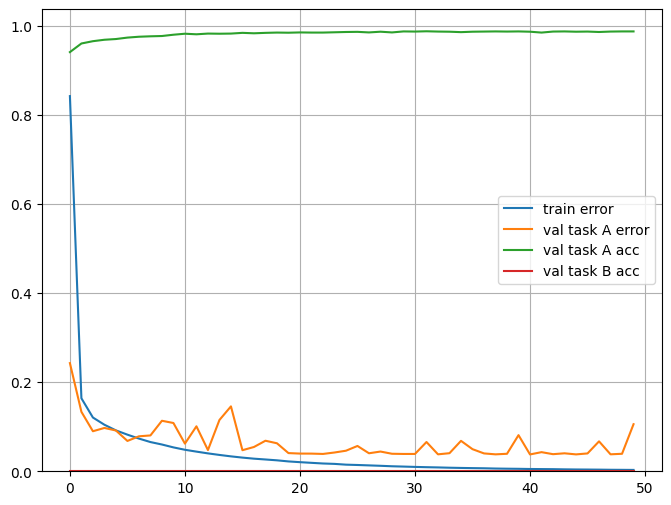

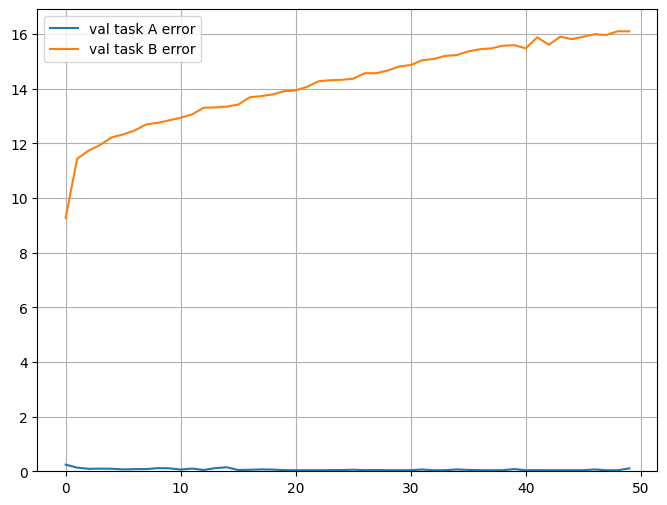

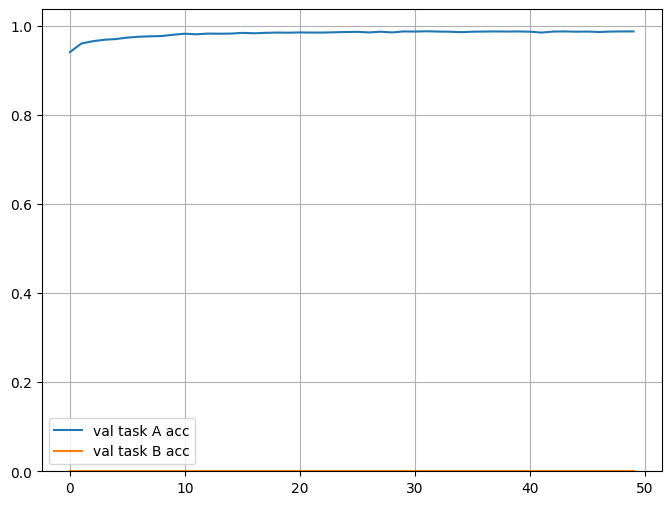

In [31]:
plt.figure(figsize=(8,6))
plt.plot(range(len(train_loss_list)), [l.cpu() for l in train_loss_list], label="train error")
plt.plot(range(0, validation_freq*len(val_A_loss_list), validation_freq), [l.cpu() for l in val_A_loss_list], label="val task A error")
plt.plot(range(0, validation_freq*len(val_A_acc_list), validation_freq), [l.cpu() for l in val_A_acc_list], label="val task A acc")
plt.plot(range(0, validation_freq*len(val_B_acc_list), validation_freq), [l.cpu() for l in val_B_acc_list], label="val task B acc")
#plt.plot(range(0, validation_freq*len(val_B_loss_list), validation_freq), [l.cpu() for l in val_B_loss_list], label="val task B error")
plt.legend()
plt.grid(True)
plt.ylim(bottom=0)
plt.show()

plt.figure(figsize=(8,6))
plt.plot(range(0, validation_freq*len(val_A_loss_list), validation_freq), [l.cpu() for l in val_A_loss_list], label="val task A error")
plt.plot(range(0, validation_freq*len(val_B_loss_list), validation_freq), [l.cpu() for l in val_B_loss_list], label="val task B error")
plt.legend()
plt.grid(True)
plt.ylim(bottom=0)
plt.show()

plt.figure(figsize=(8,6))
plt.plot(range(0, validation_freq*len(val_A_acc_list), validation_freq), [l.cpu() for l in val_A_acc_list], label="val task A acc")
plt.plot(range(0, validation_freq*len(val_B_acc_list), validation_freq), [l.cpu() for l in val_B_acc_list], label="val task B acc")
plt.legend()
plt.grid(True)
plt.ylim(bottom=0)
plt.show()

In [32]:
torch.manual_seed(0)

epochs=100

_, little_bit_of_train_dataset_A = split_dataset(train_dataset_A, split_share = 0.9)

train_dataset_B_with_a_little_bit_of_task_A = ConcatDataset([train_dataset_B, little_bit_of_train_dataset_A])

train_dataloader_B_with_a_little_bit_of_task_A = DataLoader(train_dataset_B_with_a_little_bit_of_task_A, batch_size=batch_size, shuffle=True)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate
  )

val_dataloader_A_for_EWC = DataLoader(val_dataset_A, batch_size=1, shuffle=True)

EWC = EWC_Reg(model, val_dataloader_A_for_EWC)
EWC_alpha = 100000000

model, epoch_loss_list, classification_loss_list, EWC_loss_list, val_A_loss_list, val_A_acc_list, val_B_loss_list, val_B_acc_list = learning_loop_for_classification_with_two_tasks_and_EWC(
    train_dataloader_B_with_a_little_bit_of_task_A,
    val_dataloader_A,
    val_dataloader_B,
    model,
    epochs,
    loss_fn,
    EWC,
    EWC_alpha,
    optimizer,
    validation_freq = validation_freq)

print(f"Número de parámetros {torch.tensor([p.numel() for p in model.parameters()]).sum()}")

epoch:: 100%|██████████| 100/100 [00:16<00:00,  6.17it/s, loss=261.34783935546875]

Número de parámetros 203530


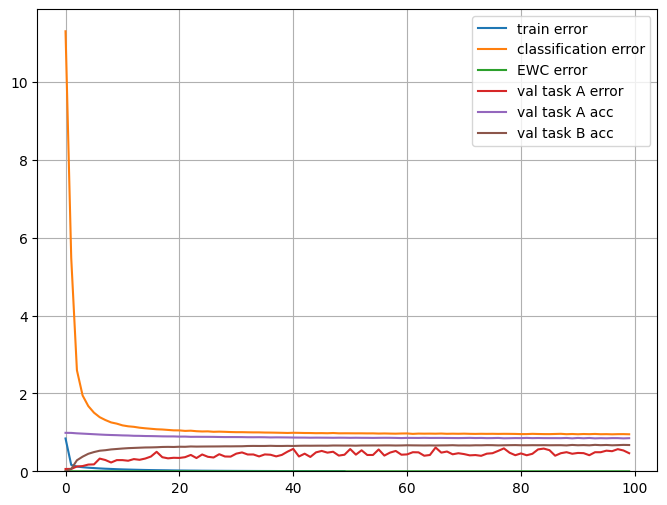

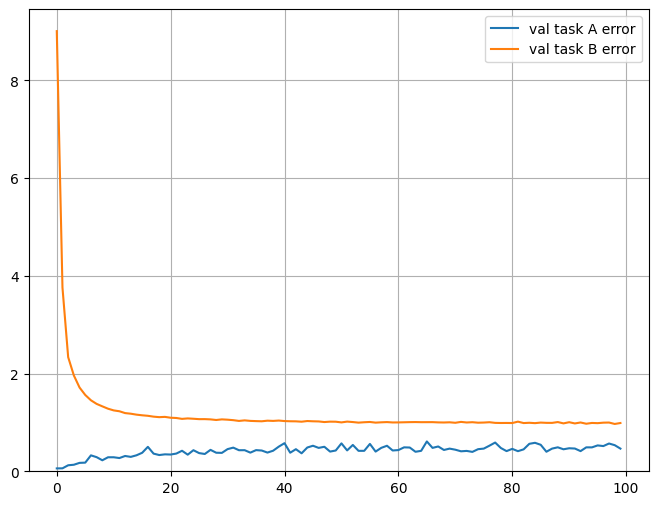

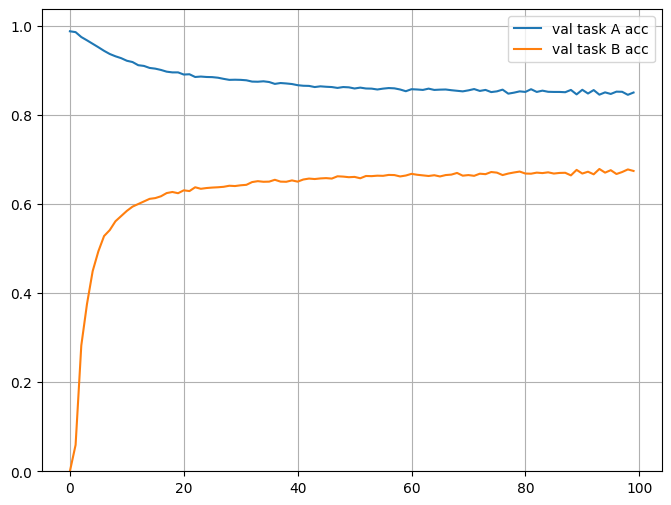

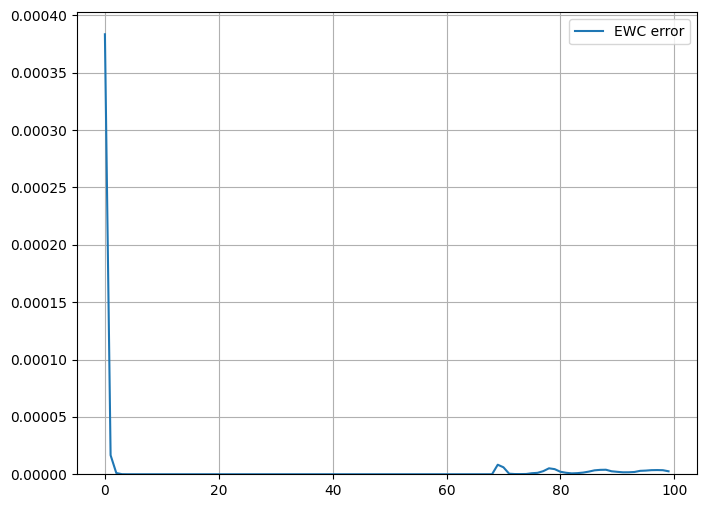

In [33]:
plt.figure(figsize=(8,6))
plt.plot(range(len(train_loss_list)), [l.cpu() for l in train_loss_list], label="train error")
plt.plot(range(len(classification_loss_list)), [l.cpu() for l in classification_loss_list], label="classification error")
plt.plot(range(len(EWC_loss_list)), [l.cpu() for l in EWC_loss_list], label="EWC error")
plt.plot(range(0, validation_freq*len(val_A_loss_list), validation_freq), [l.cpu() for l in val_A_loss_list], label="val task A error")
plt.plot(range(0, validation_freq*len(val_A_acc_list), validation_freq), [l.cpu() for l in val_A_acc_list], label="val task A acc")
plt.plot(range(0, validation_freq*len(val_B_acc_list), validation_freq), [l.cpu() for l in val_B_acc_list], label="val task B acc")
#plt.plot(range(0, validation_freq*len(val_B_loss_list), validation_freq), [l.cpu() for l in val_B_loss_list], label="val task B error")
plt.legend()
plt.grid(True)
plt.ylim(bottom=0)
plt.show()

plt.figure(figsize=(8,6))
plt.plot(range(0, validation_freq*len(val_A_loss_list), validation_freq), [l.cpu() for l in val_A_loss_list], label="val task A error")
plt.plot(range(0, validation_freq*len(val_B_loss_list), validation_freq), [l.cpu() for l in val_B_loss_list], label="val task B error")
plt.legend()
plt.grid(True)
plt.ylim(bottom=0)
plt.show()

plt.figure(figsize=(8,6))
plt.plot(range(0, validation_freq*len(val_A_acc_list), validation_freq), [l.cpu() for l in val_A_acc_list], label="val task A acc")
plt.plot(range(0, validation_freq*len(val_B_acc_list), validation_freq), [l.cpu() for l in val_B_acc_list], label="val task B acc")
plt.legend()
plt.grid(True)
plt.ylim(bottom=0)
plt.show()

plt.figure(figsize=(8,6))
plt.plot(range(len(EWC_loss_list)), [l.cpu() for l in EWC_loss_list], label="EWC error")
plt.legend()
plt.grid(True)
plt.ylim(bottom=0)
plt.show()

Mejora el resultado para la Tarea A a costa de bajar un poco la de la tarea B. La cantidad de datos y el peso que se le de al componente de Fisher permite equilibrar la eficacia para A o para B.

## Conclusiones

El problema del olvidoc atastrófico no tiene una solución general, pero hay diversas técnicas para intentar mitigarlo. Algunas de las más comunes se basan en conservar datos de las tareas anteriores o en identificar las partes de la red más críticas para una tarea.

Por suerte, no es habitual que necesitemos ampliar las tareas para las que un modelo funciona bien sin olvidar las anteriores.